In [3]:
import os
import pickle

import tqdm
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [4]:
DATA_ROOT = "../../raw/frog"
# FROG_H5 = os.path.join(DATA_ROOT, "frog_11-36_12-43_train_val.h5")
FROG_ODOM1 = os.path.join(DATA_ROOT, "frog_11-36_odom.npz")
FROM_ODOM2 = os.path.join(DATA_ROOT, "frog_12-43_odom.npz")

FROG_H5 = os.path.join(DATA_ROOT, "frog_14-57.h5")

FROG_TRAJ_RAW = "../ros_frog/bag_files/traj_raw.pkl"

In [5]:
hf = h5py.File(FROG_H5, "r")

In [6]:
list(hf.values())

[<HDF5 dataset "circle_idx": shape (70062,), type "<u4">,
 <HDF5 dataset "circle_num": shape (70062,), type "<u4">,
 <HDF5 dataset "circles": shape (133197, 6), type "<f4">,
 <HDF5 dataset "scans": shape (70062, 720), type "<f4">,
 <HDF5 dataset "timestamps": shape (70062,), type "<f8">]

In [7]:
scans = hf["scans"]
circle_idx = hf["circle_idx"]
circle_num = hf["circle_num"]
circles = hf["circles"]
timestamps = hf["timestamps"]

In [8]:
scans[0].tolist()

[inf,
 inf,
 inf,
 inf,
 inf,
 2.4070000648498535,
 2.433000087738037,
 2.4590001106262207,
 2.4809999465942383,
 2.819999933242798,
 2.8429999351501465,
 2.8429999351501465,
 2.8440001010894775,
 2.864000082015991,
 10.357000350952148,
 10.357000350952148,
 2.447000026702881,
 2.447000026702881,
 2.447000026702881,
 2.447000026702881,
 2.4630000591278076,
 2.4779999256134033,
 10.147000312805176,
 10.147000312805176,
 7.605000019073486,
 7.605000019073486,
 7.605000019073486,
 5.486000061035156,
 2.4779999256134033,
 2.4830000400543213,
 2.4830000400543213,
 2.4830000400543213,
 2.492000102996826,
 5.478000164031982,
 5.552999973297119,
 5.552999973297119,
 inf,
 inf,
 inf,
 inf,
 inf,
 2.502000093460083,
 2.510999917984009,
 2.5160000324249268,
 2.5190000534057617,
 34.433998107910156,
 34.435001373291016,
 34.441001892089844,
 34.529998779296875,
 34.5989990234375,
 34.5989990234375,
 34.5989990234375,
 2.562999963760376,
 2.549999952316284,
 2.549999952316284,
 2.549999952316284,
 

[[ 1.474      -2.125       0.4         2.586175   -0.9643468   0.15345263]]


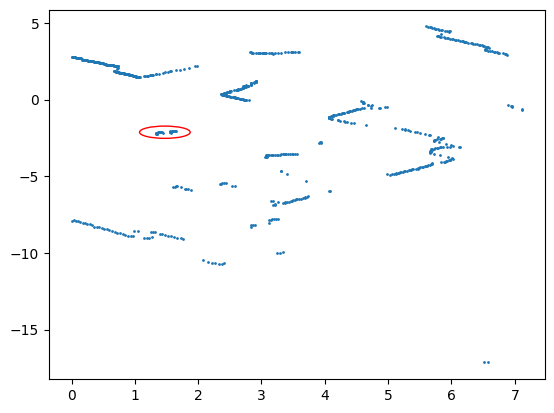

In [9]:
idx = 20000
x = scans[idx] * np.cos(np.linspace(-0.5 * np.pi, 0.5 * np.pi, scans.shape[1]))
y = scans[idx] * np.sin(np.linspace(-0.5 * np.pi, 0.5 * np.pi, scans.shape[1]))

idx = circle_idx[idx]
num = circle_num[idx]

cs = circles[idx:idx+num, :]
print(cs)

fig, ax = plt.subplots()
for i in range(cs.shape[0]):
    cx, cy, cr, _, _, _ = cs[i]
    ax.add_patch(plt.Circle((cx, cy), cr, fill=False, color='r'))
plt.plot(x, y, 'o', markersize=1)
plt.show()

In [10]:
odom1 = np.load(FROG_ODOM1)

In [11]:
odom1

NpzFile '../../raw/frog/frog_11-36_odom.npz' with keys: ts, data

In [12]:
odom1["data"].shape

(17746, 3)

In [13]:
odom1["data"][0]

array([0., 0., 0.], dtype=float32)

In [14]:
odom1["data"]

array([[  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ],
       ...,
       [ 91.217    , -23.603    ,  -1.0995574],
       [ 91.217    , -23.603    ,  -1.0995574],
       [ 91.217    , -23.603    ,  -1.0995574]], dtype=float32)

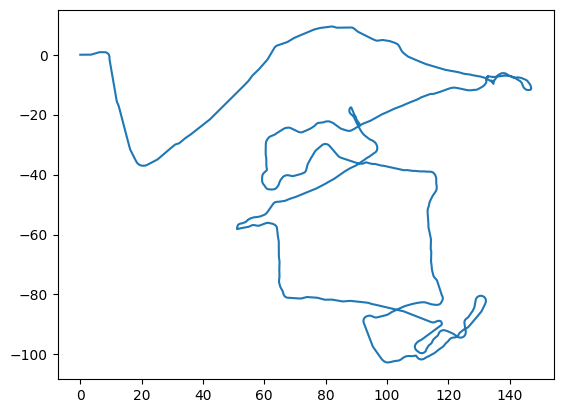

In [15]:
# Plot the trajectory
fig, ax = plt.subplots()
ax.plot(odom1["data"][:, 0], odom1["data"][:, 1])
plt.show()

In [16]:
events = []
for i in range(scans.shape[0]):
    events.append((timestamps[i], "scan", i, ""))
for i in range(odom1["data"].shape[0]):
    events.append((odom1["ts"][i], "odom", i, odom1["data"][i]))
events = sorted(events, key=lambda x: x[0])

In [17]:
len(events)

87808

## Process the localized trajectory in the given map
### Corresponds to `frog_14-57.h5`

In [34]:
FROG_H5 = os.path.join(DATA_ROOT, "frog_14-57.h5")
hf = h5py.File(FROG_H5, "r")
scans = hf["scans"]
circle_idx = hf["circle_idx"]
circle_num = hf["circle_num"]
circles = hf["circles"]
timestamps = hf["timestamps"]

In [18]:
with open(FROG_TRAJ_RAW, "rb") as fp:
    records = pickle.load(fp)

In [22]:
poses = []
for record in records:
    if record["topic"] != "/pose":
        continue
    time_ns = record["time_ns"]
    position = record["pose"]["pose"]["position"]
    orientation = record["pose"]["pose"]["orientation"]
    orientation = [orientation["x"], orientation["y"], orientation["z"], orientation["w"]]
    orientation = Rotation.from_quat(orientation).as_euler("xyz", degrees=False)
    # print(orientation)
    poses.append((time_ns, position["x"], position["y"], orientation[2]))

In [30]:
scan_idxs = []
for record in records:
    if record["topic"] != "/scan_idx":
        continue
    time_ns = record["time_ns"]
    scan_idx = record["data"]
    scan_idxs.append((time_ns, scan_idx))

In [31]:
poses = sorted(poses, key=lambda x: x[0])
scan_idxs = sorted(scan_idxs, key=lambda x: x[0])

In [32]:
def find_interpolated_pose(time_ns):
    for i in range(len(poses) - 1):
        if poses[i][0] <= time_ns and time_ns <= poses[i + 1][0]:
            t0, x0, y0, theta0 = poses[i]
            t1, x1, y1, theta1 = poses[i + 1]
            alpha = (time_ns - t0) / (t1 - t0)
            x = x0 + alpha * (x1 - x0)
            y = y0 + alpha * (y1 - y0)
            theta = theta0 + alpha * (theta1 - theta0)
            return x, y, theta
    return None

In [35]:
localized_point_clouds = []
for time_ns, idx in scan_idxs:
    pose = find_interpolated_pose(time_ns)
    x = scans[idx] * np.cos(np.linspace(-0.5 * np.pi, 0.5 * np.pi, scans.shape[1]))
    y = scans[idx] * np.sin(np.linspace(-0.5 * np.pi, 0.5 * np.pi, scans.shape[1]))

    idx = circle_idx[idx]
    num = circle_num[idx]

    cs = circles[idx:idx+num, :]
    
    localized_point_clouds.append({
        "pose": pose,
        "x": x,
        "y": y,
        "circles": cs
    })

In [38]:
localized_point_clouds_with_dynobts = [
    d for d in localized_point_clouds if len(d["circles"]) > 0
]

In [39]:
len(localized_point_clouds_with_dynobts)

3960

In [41]:
with open("../../../resources/obstacles/localized_point_clouds_with_dynobts.pkl", "wb") as fp:
    pickle.dump(localized_point_clouds_with_dynobts, fp)

### Generate q0 + dynobst dataset

In [58]:
import sdsl
from sdsl.simulation import *

import shapely
import pointpats

In [59]:
env = sdsl.load_poly_file("../../../resources/maps/frog.poly")

In [78]:
def process_scan(d):
    if d["pose"] is None:
        return None, None, None
    q_x, q_y, q_r = d["pose"]
    circles = d["circles"]
    dynamic_obstacles = []
    for i in range(circles.shape[0]):
        x, y, r, _, _, _ = circles[i]
        x_ = x * np.cos(q_r) - y * np.sin(q_r) + q_x
        y_ = x * np.sin(q_r) + y * np.cos(q_r) + q_y
        dynamic_obstacles.append(DynamicObstacle_Disc2D(x_, y_, r))
    
    q0 = R2xS1(q_x, q_y, q_r)
    odometry = get_odometry(16, 0.02)
    measurements = get_measurements(env, odometry, q0, [])

    points = []
    for g, d in zip(odometry, measurements):
        if d > 10: 
            continue
        q = g * q0
        x = q.x() + d * np.cos(q.r())
        y = q.y() + d * np.sin(q.r())
        points.append((x, y))
    
    polygon = shapely.convex_hull(shapely.geometry.MultiPoint(points))

    return polygon, dynamic_obstacles, odometry

In [79]:
def generate_scenario(d):
    polygon, dynamic_obstacles, odometry = process_scan(d)
    if polygon is None:
        return None

    num_tries = 0
    while True:
        x, y = pointpats.random.poisson(polygon, size=1)
        r = np.random.uniform(0, 2 * np.pi)
        q0 = R2xS1(x, y, r)
        
        if verify_scenario(env, dynamic_obstacles, q0, odometry):
            return q0, dynamic_obstacles, odometry
        
        num_tries += 1
        if num_tries > 10:
            return None

In [80]:
scenarios = []
for d in tqdm.tqdm(localized_point_clouds_with_dynobts):
    for i in range(10):
        scenario = generate_scenario(d)
        if scenario is not None:
            scenarios.append(scenario)

100%|██████████| 3960/3960 [04:14<00:00, 15.56it/s]


In [82]:
pickle_scenarios = []
for scenario in scenarios:
    q0, dynamic_obstacles, odometry = scenario
    q0_ = (q0.x(), q0.y(), q0.r())
    odometry_ = [(g.x(), g.y(), g.r()) for g in odometry]
    pickle_scenarios.append((q0_, dynamic_obstacles, odometry_))

In [83]:
with open("../../../resources/obstacles/scenarios.pkl", "wb") as fp:
    pickle.dump(pickle_scenarios, fp)

In [84]:
pickle_scenarios[0]

((13.80030412473338, -34.411939252720934, 0.2974235699810598),
 [(0.02, 0.0, 0.0),
  (0.018477590650225736, 0.007653668647301796, 0.39269908169872414),
  (0.014142135623730952, 0.014142135623730949, 0.7853981633974483),
  (0.007653668647301797, 0.018477590650225736, 1.1780972450961724),
  (1.2246467991473532e-18, 0.02, 1.5707963267948966),
  (-0.007653668647301794, 0.018477590650225736, 1.9634954084936207),
  (-0.014142135623730949, 0.014142135623730952, 2.356194490192345),
  (-0.018477590650225736, 0.007653668647301798, 2.748893571891069),
  (-0.02, 2.4492935982947064e-18, 3.141592653589793),
  (-0.018477590650225736, -0.0076536686473017935, 3.5342917352885173),
  (-0.014142135623730954, -0.014142135623730949, 3.9269908169872414),
  (-0.0076536686473018065, -0.01847759065022573, 4.319689898685965),
  (-3.673940397442059e-18, -0.02, 4.71238898038469),
  (0.0076536686473018005, -0.018477590650225733, 5.105088062083414),
  (0.014142135623730947, -0.014142135623730954, 5.497787143782138),